In [1]:
# =========================
# CME with AR model — same behavior, refactored
# =========================
import math, torch, numpy as np
import torch.nn.functional as F
from torch import nn
from torch.func import vmap
from torchrl.modules.tensordict_module.rnn import LSTMCell

# ---------------- utils --------------------------------------------
def remap(t, range=(0, 100), scale=None):
    return t  # no remap for now
    if scale is None:
        scale = range[1] - range[0]
    t = t / range[1]
    return (t * 2 - 1)*scale

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- lattice & lookup ---------------------------------
M_MAX, P_MAX = 8, 8
N_STATES = (M_MAX + 1) * (P_MAX + 1)

# ---------------- CME parameters -----------------------------------
class GeneExpressionCRN:
    def __init__(self, k_r=2, k_p=2, g_r=2, g_p=2):
        self.k_r, self.k_p, self.g_r, self.g_p = k_r, k_p, g_r, g_p

# ---------------- helpers ------------------------------------------

def elementwise_rl_residual(dpdt, current_p, Ap_val_detached, *, eps=1e-3):
    num = (dpdt - Ap_val_detached)
    denom = current_p.detach().clamp_min(eps)
    return (num / denom)**2  # [N,B]

@torch.no_grad()
def _p_tplus(net, oh_m, oh_p, oh_m_soft, t, delta_t):
    return vmap(lambda ohm, ohp, ohms, tt: net.get_probability(ohm, ohp, ohms, tt + delta_t), (0, 0, 0, 0))(
        oh_m, oh_p, oh_m_soft, t
    ).clamp_min(1e-9)

def loss_temporal_consistency(net, oh_m, oh_p, oh_m_soft, t, current_p, Ap_val_detached, delta_t):
    p_tplus = _p_tplus(net, oh_m, oh_p, oh_m_soft, t, delta_t)  # teacher
    return ((p_tplus - (current_p + delta_t * Ap_val_detached)) ** 2).mean()

def prob_mp(net, t_vec, m_vec, p_vec):
    oh_m = F.one_hot(m_vec.clamp(0, M_MAX).long(), M_MAX+1).float()
    oh_p = F.one_hot(p_vec.clamp(0, P_MAX).long(), P_MAX+1).float()
    return net.get_probability(oh_m, oh_p, oh_m, t_vec)

def loss_ic(net):
     # initial condition at t=0: delta at (0,0)
    K0 = 512
    t0 = torch.zeros(K0, device=DEVICE)
    m0 = torch.randint(0, M_MAX+1, (K0,), device=DEVICE)
    p0 = torch.randint(0, P_MAX+1, (K0,), device=DEVICE)
    prob0 = prob_mp(net, t0, m0, p0)
    target0 = ((m0 == 0) & (p0 == 0)).float()
    ic_loss = F.mse_loss(prob0, target0)
    return ic_loss

def loss_entropy(entropy_m, entropy_p):
    return -(entropy_m + entropy_p).mean()

# ---------------- utils --------------------------------------------

def idx_to_onehot(idx, num_classes):
    return F.one_hot(idx.clamp(0, num_classes - 1).long(), num_classes).float()

@torch.no_grad()
def _all_states_onehot():
    m_all = torch.arange(M_MAX + 1, device=DEVICE)
    p_all = torch.arange(P_MAX + 1, device=DEVICE)
    m_mesh = m_all.repeat_interleave(P_MAX + 1)
    p_mesh = p_all.repeat(M_MAX + 1)
    oh_m_all = F.one_hot(m_mesh, M_MAX + 1).float()
    oh_p_all = F.one_hot(p_mesh, P_MAX + 1).float()
    return oh_m_all, oh_p_all, m_mesh, p_mesh

@torch.no_grad()
def mass_at(net, t_scalar):
    oh_m_all, oh_p_all, _, _ = _all_states_onehot()
    t_vec = torch.full((N_STATES,), float(t_scalar), device=DEVICE)
    p_all = net.get_probability(oh_m_all, oh_p_all, oh_m_all, t_vec).clamp_min(0)
    return p_all.sum().item()

# ---------------- positional encoding ------------------------------
class PosEnc(nn.Module):
    def __init__(self, n_freq=6):
        super().__init__()
        self.register_buffer("f", 2 ** torch.arange(n_freq).float() * math.pi)
    def forward(self, t):
        t = t[..., None]  # [B,1]
        return torch.cat([torch.sin(t * self.f), torch.cos(t * self.f)], dim=-1)
    
# ---------------- small helpers --------------------

def ic_loss(net, K0=512):
    t0 = torch.zeros(K0, device=DEVICE)
    m0 = torch.randint(0, M_MAX+1, (K0,), device=DEVICE)
    p0 = torch.randint(0, P_MAX+1, (K0,), device=DEVICE)
    prob0 = prob_mp(net, t0, m0, p0)
    target0 = ((m0 == 0) & (p0 == 0)).float()
    return F.mse_loss(prob0, target0)

def entropy_term(entropy_m, entropy_p):
    # same sign/convention as your script
    return -(entropy_m + entropy_p)

def ap_local(net, crn, t, m, p):
    """Compute (A p)(m,p,t) with the same neighbor logic."""
    k_r = torch.tensor(crn.k_r, device=DEVICE, dtype=torch.float32)
    k_p = torch.tensor(crn.k_p, device=DEVICE, dtype=torch.float32)
    g_r = torch.tensor(crn.g_r, device=DEVICE, dtype=torch.float32)
    g_p = torch.tensor(crn.g_p, device=DEVICE, dtype=torch.float32)

    m_prev = (m - 1).clamp(0, M_MAX); m_next = (m + 1).clamp(0, M_MAX)
    p_prev = (p - 1).clamp(0, P_MAX); p_next = (p + 1).clamp(0, P_MAX)

    valid_m_prev = (m > 0).float()
    valid_m_next = (m < M_MAX).float()
    valid_p_prev = (p > 0).float()
    valid_p_next = (p < P_MAX).float()

    p_m_prev = prob_mp(net, t, m_prev, p) * valid_m_prev
    p_m_next = prob_mp(net, t, m_next, p) * valid_m_next
    p_p_prev = prob_mp(net, t, m, p_prev) * valid_p_prev
    p_p_next = prob_mp(net, t, m, p_next) * valid_p_next

    inflow  = k_r * p_m_prev \
            + g_r * (m + 1).float() * p_m_next \
            + k_p * m.float() * p_p_prev \
            + g_p * (p + 1).float() * p_p_next

    outflow = (k_r + g_r*m.float() + k_p*m.float() + g_p*p.float()) * prob_mp(net, t, m, p)
    return inflow - outflow

def sample_from_model(net, t, K):
    """Exact same sampling you used (via net.forward + vmap)."""
    m, p, oh_m, oh_p, entropy_m, entropy_p, _, sampling_probability = vmap(
        lambda _, tt: net(tt), (0, 0), randomness="different"
    )(torch.zeros(K, device=DEVICE), t)
    # squeeze to match later usage
    m = m.squeeze(-1); p = p.squeeze(-1)
    return m, p, oh_m, oh_p, entropy_m, entropy_p, sampling_probability


In [2]:


# ---------------- autoregressive pθ(m,p | t) -----------------------
class ARProbNet(nn.Module):
    def __init__(self, hidden=128, n_freq=6, tau=1.0, batch_size=256):
        super().__init__()
        self.tau = torch.nn.Parameter(torch.tensor(tau), requires_grad=False)
        self.batch_size = batch_size
        self.device = DEVICE

        self.pe = PosEnc(n_freq)
        self.time_emb = nn.Sequential(
            nn.Linear(2 * n_freq, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
        )
        self.lstm = LSTMCell(2 * n_freq, hidden)

        self.m_proj = nn.Linear(M_MAX + 1, 2 * n_freq)

        self.head_m = nn.Linear(hidden, M_MAX + 1)
        self.head_p = nn.Linear(hidden, P_MAX + 1)

        self.register_buffer("m_norm", torch.linspace(0, 1, M_MAX + 1))
        self.register_buffer("p_norm", torch.linspace(0, 1, P_MAX + 1))
        self.register_buffer("m_grid", torch.arange(M_MAX + 1, device=DEVICE).float())
        self.register_buffer("p_grid", torch.arange(P_MAX + 1, device=DEVICE).float())

    def forward(self, t):
        # --- encode time
        x0 = remap(t)
        pe_t = self.pe(x0)
        h = self.time_emb(pe_t); c = h.clone()

        # --- m ~ p(m|t)
        h, c = self.lstm(pe_t, (h, c))
        logits_m = self.head_m(h)
        dist_m = torch.distributions.RelaxedOneHotCategorical(temperature=self.tau, logits=logits_m)
        oh_m_soft = dist_m.rsample()
        oh_m_hard = F.one_hot(oh_m_soft.argmax(dim=-1), logits_m.size(-1)).float()
        oh_m = oh_m_hard + (oh_m_soft - oh_m_soft.detach())
        m_scalar = (oh_m_hard * self.m_grid).sum(-1, keepdim=True)

        # --- p ~ p(p|m,t)
        # m_cond = self.m_proj(oh_m_soft)
        m_cond = self.m_proj(oh_m)
        cond_p = pe_t + m_cond
        h, c = self.lstm(cond_p, (h, c))
        logits_p = self.head_p(h)
        dist_p = torch.distributions.RelaxedOneHotCategorical(temperature=self.tau, logits=logits_p)
        oh_p_soft = dist_p.rsample()
        oh_p_hard = F.one_hot(oh_p_soft.argmax(dim=-1), logits_p.size(-1)).float()
        oh_p = oh_p_hard + (oh_p_soft - oh_p_soft.detach())
        p_scalar = (oh_p_hard * self.p_grid).sum(-1, keepdim=True)

        entropy_m = torch.distributions.Categorical(logits=logits_m).entropy()
        entropy_p = torch.distributions.Categorical(logits=logits_p).entropy()

        # discrete joint prob for sampled (m,p)
        log_p_m = torch.log_softmax(logits_m, dim=-1)
        log_p_p = torch.log_softmax(logits_p, dim=-1)
        log_total = (log_p_m * oh_m_hard).sum(-1) + (log_p_p * oh_p_hard).sum(-1)
        total_prob = log_total.exp()

        return m_scalar, p_scalar, oh_m, oh_p, entropy_m, entropy_p, oh_m_soft, total_prob

    def get_probability(self, oh_m, oh_p, oh_m_soft, t):
        x0 = remap(t)
        pe_t = self.pe(x0)
        h = self.time_emb(pe_t); c = h.clone()

        # p(m|t)
        h, c = self.lstm(pe_t, (h, c))
        logits_m = self.head_m(h)
        p_m = torch.softmax(logits_m, dim=-1)
        p_m_chosen = (p_m * oh_m).sum(-1)

        # p(p|m,t)
        # m_cond = self.m_proj(oh_m_soft)
        m_cond = self.m_proj(oh_m)
        cond_p = pe_t + m_cond
        h, c = self.lstm(cond_p, (h, c))
        logits_p = self.head_p(h)
        p_p_m = torch.softmax(logits_p, dim=-1)
        p_p_chosen = (p_p_m * oh_p).sum(-1)

        return p_m_chosen * p_p_chosen






In [3]:
# ------- add this helper next to sample_from_model -----------------
def sample_mixture(net, t, K, alpha):
    """Return a mixture of NN and uniform samples plus q-prob for IS."""
    Km = int(round(K * alpha))
    Ku = K - Km
    assert Km >= 0 and Ku >= 0

    # split times (both parts keep requires_grad from t)
    tm, tu = t[:Km], t[Km:]

    # NN part (same as before)
    if Km > 0:
        m_m, p_m, oh_m_m, oh_p_m, ent_m_m, ent_p_m, ptheta_m = sample_from_model(net, tm, Km)
    else:
        m_m = p_m = oh_m_m = oh_p_m = ent_m_m = ent_p_m = ptheta_m = None

    # Uniform part
    if Ku > 0:
        m_u = torch.randint(0, M_MAX + 1, (Ku,), device=DEVICE)
        p_u = torch.randint(0, P_MAX + 1, (Ku,), device=DEVICE)
        oh_m_u = idx_to_onehot(m_u, M_MAX + 1)
        oh_p_u = idx_to_onehot(p_u, P_MAX + 1)
        # entropies not meaningful for uniform picks; keep zeros
        ent_m_u = torch.zeros(Ku, device=DEVICE)
        ent_p_u = torch.zeros(Ku, device=DEVICE)
        # pθ for uniform picks (used for importance weights)
        ptheta_u = prob_mp(net, tu, m_u, p_u)
    else:
        m_u = p_u = oh_m_u = oh_p_u = ent_m_u = ent_p_u = ptheta_u = None


    # concat everything in original order: [NN | UNI]
    def cat(a, b): 
        if a is None: return b
        if b is None: return a
        return torch.cat([a, b], dim=0)

    m          = cat(m_m, m_u)
    p          = cat(p_m, p_u)
    oh_m       = cat(oh_m_m, oh_m_u)
    oh_p       = cat(oh_p_m, oh_p_u)
    entropy_m  = cat(ent_m_m, ent_m_u)
    entropy_p  = cat(ent_p_m, ent_p_u)
    ptheta     = cat(ptheta_m, ptheta_u)  # pθ(m,p|t) for each sampled pair

    # mixture q = α pθ + (1-α) U
    u_prob = 1.0 / float(N_STATES)
    q_prob = alpha * ptheta + (1.0 - alpha) * u_prob
    return m, p, oh_m, oh_p, entropy_m, entropy_p, ptheta, q_prob

# ------- modify train_minimal signature & body ---------------------
def train_minimal(
    crn, net, *, steps=10000, K=4096, lr=3e-4, t_max=1.5, report=200,
    mix_alpha=None, unbiased_is=True, w_clip=None
):
    net.pe.t_max = t_max if hasattr(net.pe, "t_max") else t_max
    opt = torch.optim.Adam(net.parameters(), lr)
    eps = 5e-3

    for step in range(1, steps + 1):
        # times
        t = torch.rand(K, device=DEVICE, requires_grad=True) * t_max

        # sampling (pure NN vs mixture)
        if mix_alpha is None or float(mix_alpha) >= 0.9999:
            m, p, oh_m, oh_p, entropy_m, entropy_p, ptheta = sample_from_model(net, t, K)
            q_prob = ptheta  # q == pθ
            alpha_eff = 1.0
        else:
            alpha_eff = float(mix_alpha)
            m, p, oh_m, oh_p, entropy_m, entropy_p, ptheta, q_prob = sample_mixture(net, t, K, alpha_eff)

        # p and dp/dt at sampled (m,p,t)
        p_cur = prob_mp(net, t, m, p)
        dpdt  = torch.autograd.grad(p_cur, t, grad_outputs=torch.ones_like(p_cur), create_graph=True)[0]

        # A p
        Ap = ap_local(net, crn, t, m, p)

        # base integrand (your relative residual)
        integrand = ((dpdt - Ap)**2) / (p_cur.detach().clamp_min(eps)**2)

        # importance weights to keep target = E_{pθ}[integrand]
        # w = pθ / q, detached to avoid grads through the sampler
        w = (p_cur.detach() / q_prob.clamp_min(1e-12)).detach()
        if w_clip is not None:
            w = w.clamp(max=float(w_clip))

        if unbiased_is:
            res_loss = (w * integrand).mean()
        else:
            w_norm = w / (w.mean().clamp_min(1e-12))
            res_loss = (w_norm * integrand).mean()

        # IC + (optional) entropy
        ic = ic_loss(net)
        ent = entropy_term(entropy_m, entropy_p).mean()
        loss = res_loss + 0.5 * ic  # + 0.01 * ent

        # step
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        opt.step()

        # tau decay (unchanged)
        if step >= 600 and step % 200 == 0:
            net.tau.mul_(0.95).clamp_(min=0.5)

        # logs
        if step % report == 0 or step == 1:
            with torch.no_grad():
                rmse = (dpdt - Ap).pow(2).mean().sqrt().item()
                d_mean = dpdt.abs().mean().item()
                a_mean = Ap.abs().mean().item()
                oh_m_all, oh_p_all, _, _ = _all_states_onehot()
                t_mid = torch.full((N_STATES,), t_max*0.5, device=DEVICE)
                mass_mid = net.get_probability(oh_m_all, oh_p_all, oh_m_all, t_mid).clamp_min(0).sum().item()

                # simple ESS estimate (normalized IS)
                ess = w.sum().pow(2) / (w.pow(2).sum().clamp_min(1e-12)).item()

            print(
                f"step {step:5d} | loss {loss.item():.3e} | res {res_loss.item():.3e} | ic {ic.item():.3e} "
                f"| rmse {rmse:.3e} | |dpdt| {d_mean:.3e} | |Ap| {a_mean:.3e} "
                f"| mass@mid {mass_mid:.3f} | entropy {ent.item():.3e} "
                f"| mixα {alpha_eff:.2f} | ESS ~ {ess:.0f}/{K} ({ess/K:.2f})"
            )

# ------- usage example ---------------------------------------------
crn = GeneExpressionCRN(k_r=4, k_p=4, g_r=2, g_p=2)
net = ARProbNet(hidden=64, tau=5.0).to(DEVICE)
train_minimal(crn, net, steps=100000, K=8192, lr=1e-3, t_max=1.5,
              mix_alpha=0.9, unbiased_is=True, w_clip=50.0, report=200)


step     1 | loss 1.128e+02 | res 1.128e+02 | ic 5.856e-03 | rmse 1.339e-01 | |dpdt| 2.070e-02 | |Ap| 9.130e-02 | mass@mid 1.000 | entropy -3.951e+00 | mixα 0.90 | ESS ~ 8191/8192 (1.00)
step   200 | loss 3.705e+00 | res 3.699e+00 | ic 1.207e-02 | rmse 3.412e-02 | |dpdt| 1.008e-02 | |Ap| 2.924e-02 | mass@mid 1.000 | entropy -3.407e+00 | mixα 0.90 | ESS ~ 8016/8192 (0.98)
step   400 | loss 3.732e-01 | res 3.672e-01 | ic 1.210e-02 | rmse 1.422e-02 | |dpdt| 1.637e-02 | |Ap| 2.139e-02 | mass@mid 1.000 | entropy -3.348e+00 | mixα 0.90 | ESS ~ 7981/8192 (0.97)
step   600 | loss 1.105e-01 | res 1.064e-01 | ic 8.181e-03 | rmse 9.893e-03 | |dpdt| 1.370e-02 | |Ap| 1.514e-02 | mass@mid 1.000 | entropy -3.297e+00 | mixα 0.90 | ESS ~ 7955/8192 (0.97)
step   800 | loss 6.936e-02 | res 6.434e-02 | ic 1.004e-02 | rmse 7.957e-03 | |dpdt| 1.028e-02 | |Ap| 1.183e-02 | mass@mid 1.000 | entropy -3.276e+00 | mixα 0.90 | ESS ~ 7939/8192 (0.97)
step  1000 | loss 5.753e-02 | res 5.257e-02 | ic 9.915e-03 | rmse

KeyboardInterrupt: 

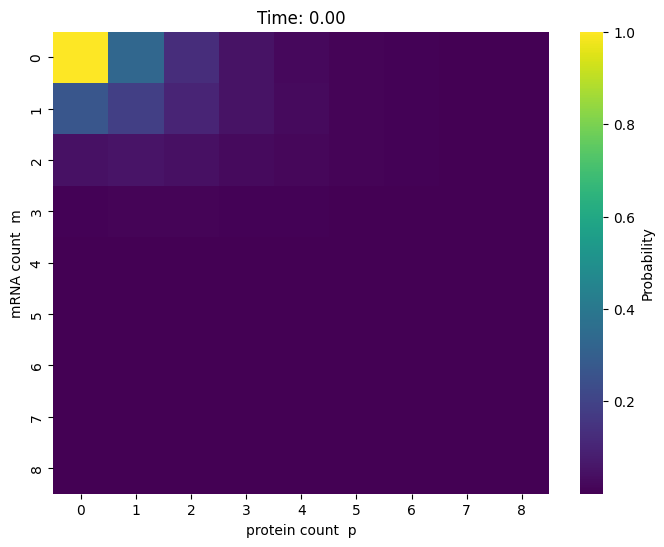

In [4]:
# PLOT SOLUTION
# ------------------------------------------------------------
# 6.  Single helper that can create *or* update a heat-map
# ------------------------------------------------------------
@torch.no_grad()
def plot_heatmap(net, t, ax=None, hm=None, title=None, normalize="max"):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import inspect

    # Ensure t is scalar tensor on DEVICE
    if isinstance(t, (float, int)):
        t_val = torch.tensor(float(t), device=DEVICE)
    elif isinstance(t, torch.Tensor) and t.numel() == 1:
        t_val = t.flatten()[0].to(DEVICE)
    else:
        raise ValueError("t must be a scalar or length-1 tensor.")

    # Vectorized (m,p) grid → one-hots
    m_grid = torch.arange(M_MAX + 1, device=DEVICE)
    p_grid = torch.arange(P_MAX + 1, device=DEVICE)
    M, P = torch.meshgrid(m_grid, p_grid, indexing="ij")
    oh_m = idx_to_onehot(M.flatten(), M_MAX + 1)  # [N, M+1]
    oh_p = idx_to_onehot(P.flatten(), P_MAX + 1)  # [N, P+1]
    t_vec = t_val.expand(oh_m.shape[0])

    # For the new API, use hard one-hot as "soft" conditioning too
    def _eval_probs(oh_m_, oh_p_, t_):
        # Try new signature: (oh_m, oh_p, oh_m_soft, t)
        try:
            return net.get_probability(oh_m_, oh_p_, oh_m_, t_)
        except TypeError:
            # Fallback to old signature: (oh_m, oh_p, t)
            return net.get_probability(oh_m_, oh_p_, t_)

    prob = _eval_probs(oh_m, oh_p, t_vec)  # [N]
    probs = prob.clamp_min(0).detach().cpu().numpy().reshape(M_MAX + 1, P_MAX + 1)

    # Optional normalization for visualization
    if normalize == "max":
        m = probs.max()
        if m > 0:
            probs = probs / m
    elif normalize == "sum":
        s = probs.sum()
        if s > 0:
            probs = probs / s
    # else: raw scale

    if hm is None or ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        hm = sns.heatmap(
            probs,
            cmap="viridis",
            cbar_kws={'label': 'Probability'},
            ax=ax, annot=False
        )
        ax.set_xlabel("protein count  p")
        ax.set_ylabel("mRNA count  m")
    else:
        # Robust update
        hm.collections[0].set_array(probs.ravel())
        hm.collections[0].autoscale()  # keep colorbar sane if not normalized
        hm.figure.canvas.draw_idle()

    if title is not None:
        ax.set_title(title)
    return ax, hm


# ------------------------------------------------------------
# updated animate_heatmap – returns the animation object
# ------------------------------------------------------------
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def animate_heatmap(net, t_max=10.0, num_frames=50, normalize="max"):
    # first frame
    t0 = torch.tensor(0.0, device=DEVICE)
    ax, hm = plot_heatmap(net, t0, title="Time: 0.00", normalize=normalize)

    def update(frame):
        t_val = frame * t_max / max(1, (num_frames - 1))
        t_tensor = torch.tensor(t_val, device=DEVICE)
        plot_heatmap(
            net, t_tensor, ax=ax, hm=hm,
            title=f"Time: {t_val:.2f}", normalize=normalize
        )
        return hm.collections

    ani = animation.FuncAnimation(
        hm.figure, update,
        frames=num_frames, blit=False, repeat=True
    )
    return ani


# ------------------------------------------------------------
# Usage after training:
# ------------------------------------------------------------
ani = animate_heatmap(net, t_max=1.5, num_frames=50)
# save as GIF 
ani.save("gene_expression_softmax.gif", writer='pillow', fps=10)


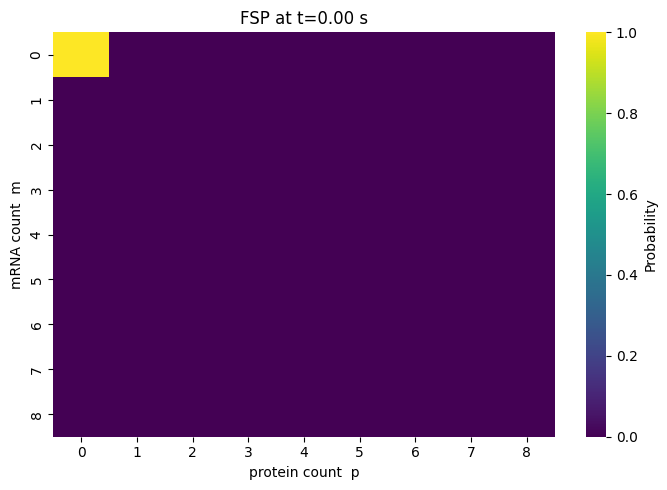

animation saved ➜ gene_expression_fsp.gif


In [5]:
# FSP

import numpy as np
import scipy.sparse as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 1. Enumerate lattice states and make {state → index} map
# ------------------------------------------------------------------
states = [(m, p) for m in range(M_MAX + 1) for p in range(P_MAX + 1)]
idx_of = {s: i for i, s in enumerate(states)}
N = len(states)

# ------------------------------------------------------------------
# 2. Build sparse generator matrix A  (dp/dt = A p)
# ------------------------------------------------------------------
def build_generator(crn):
    rows, cols, data = [], [], []
    k_r, k_p, g_r, g_p = crn.k_r, crn.k_p, crn.g_r, crn.g_p

    for (m, p), i in idx_of.items():
        # ---------- inflow to (m,p) ----------
        # transcription: (m-1,p) -> (m,p) at rate k_r
        if m > 0:
            j = idx_of[(m - 1, p)]
            rows.append(i); cols.append(j); data.append(k_r)

        # translation: (m,p-1) -> (m,p) at rate k_p * m  (depends on m of source, which equals current m)
        if p > 0:
            j = idx_of[(m, p - 1)]
            rows.append(i); cols.append(j); data.append(k_p * m)

        # mRNA degradation: (m+1,p) -> (m,p) at rate g_r * (m+1)
        if m < M_MAX:
            j = idx_of[(m + 1, p)]
            rows.append(i); cols.append(j); data.append(g_r * (m + 1))

        # protein degradation: (m,p+1) -> (m,p) at rate g_p * (p+1)
        if p < P_MAX:
            j = idx_of[(m, p + 1)]
            rows.append(i); cols.append(j); data.append(g_p * (p + 1))

        # ---------- diagonal (outflow from (m,p) that STAYS INSIDE BOX) ----------
        out = 0.0
        if m < M_MAX: out += k_r            # (m,p)->(m+1,p)
        if m > 0:     out += g_r * m        # (m,p)->(m-1,p)
        if p < P_MAX: out += k_p * m        # (m,p)->(m,p+1)
        if p > 0:     out += g_p * p        # (m,p)->(m,p-1)

        rows.append(i); cols.append(i); data.append(-out)

    A = sp.csr_matrix((data, (rows, cols)), shape=(N, N), dtype=float)
    return A

A = build_generator(GeneExpressionCRN())   # reuse later

# ------------------------------------------------------------------
# 3. FSP ODE rhs  (vectorised)
# ------------------------------------------------------------------
def fsp_ode(t, y, A):
    return A.dot(y)

# ------------------------------------------------------------------
# 4. Solve
# ------------------------------------------------------------------
def solve_fsp(crn, t_span=(0, 10), y0=None, steps=100):
    if y0 is None:
        y0 = np.zeros(N); 
        
        for i in range(1):
            y0[idx_of[(i, i)]] = 1 / 1

    t_eval = np.linspace(t_span[0], t_span[1], steps)
    sol = solve_ivp(
        fsp_ode, t_span, y0,
        args=(build_generator(crn),),
        t_eval=t_eval, rtol=1e-6, atol=1e-9
    )
    return sol.t, sol.y          # y shape (N, len(t_eval))

import numpy as np, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.animation as animation

# ------------------------------------------------------------------
# 5.  Heat-map helper (stand-alone *or* hosted)
# ------------------------------------------------------------------
def plot_fsp_heat(y_flat, *, ax=None, annotate=True, title=None, normalize=None):
    """
    y_flat   : 1-D numpy array of size N_STATES
    normalize: 'max', 'sum', or None
    ax       : optional matplotlib axis; if None a new fig/ax is made
    returns  : (ax, im, txts) where im is the QuadMesh and txts a list of
               annotation Text objects (possibly empty).
    """
    grid = y_flat.reshape(M_MAX + 1, P_MAX + 1)

    # Optional normalization
    if normalize == "max":
        m = grid.max()
        if m > 0:
            grid = grid / m
    elif normalize == "sum":
        s = grid.sum()
        if s > 0:
            grid = grid / s

    own_fig = ax is None
    if own_fig:
        fig, ax = plt.subplots(figsize=(7, 5))

    im = sns.heatmap(
        grid, ax=ax, cmap="viridis",
        cbar_kws={'label': 'Probability'}, annot=False
    )

    txts = []
    if annotate:
        for (i, j), val in np.ndenumerate(grid):
            txts.append(
                ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                        ha='center', va='center', color='black', fontsize=7)
            )

    ax.set_xlabel("protein count  p")
    ax.set_ylabel("mRNA count  m")
    if title:
        ax.set_title(title)

    if own_fig:
        plt.tight_layout(); plt.show()

    return ax, im, txts


# ------------------------------------------------------------------
# 6.  Animate the full CME evolution using plot_fsp_heat
# ------------------------------------------------------------------
def animate_fsp(t, y, *, annotate=False, fps=10, outfile="fsp_evolution.gif", normalize="max"):
    """
    t         : 1-D array of time points     (len T)
    y         : 2-D array shape (N_STATES, T)
    normalize : 'max', 'sum', or None
    """
    # initial frame
    ax, im, txts = plot_fsp_heat(
        y[:, 0], annotate=annotate, normalize=normalize,
        title=f"FSP at t={t[0]:.2f} s"
    )

    def update(frame):
        grid = y[:, frame].reshape(M_MAX + 1, P_MAX + 1)

        # normalization
        if normalize == "max":
            m = grid.max()
            if m > 0:
                grid = grid / m
        elif normalize == "sum":
            s = grid.sum()
            if s > 0:
                grid = grid / s

        im.collections[0].set_array(grid.ravel())

        if annotate:
            for txt, val in zip(txts, grid.ravel()):
                txt.set_text(f"{val:.2f}")

        ax.set_title(f"FSP at t={t[frame]:.2f} s")
        return im.collections + txts

    ani = animation.FuncAnimation(
        im.figure, update, frames=len(t),
        blit=False, repeat=True
    )
    ani.save(outfile, writer='pillow', fps=fps)
    print(f"animation saved ➜ {outfile}")
    return ani


# ------------------------------------------------------------------
# Example run
# ------------------------------------------------------------------
crn  = GeneExpressionCRN(k_r=4, k_p=4, g_r=2, g_p=2)
t, y = solve_fsp(crn, t_span=(0, 1.5), steps=50)   # y shape (N_STATES, T)

animate_fsp(t, y, annotate=False, fps=10, outfile="gene_expression_fsp.gif")


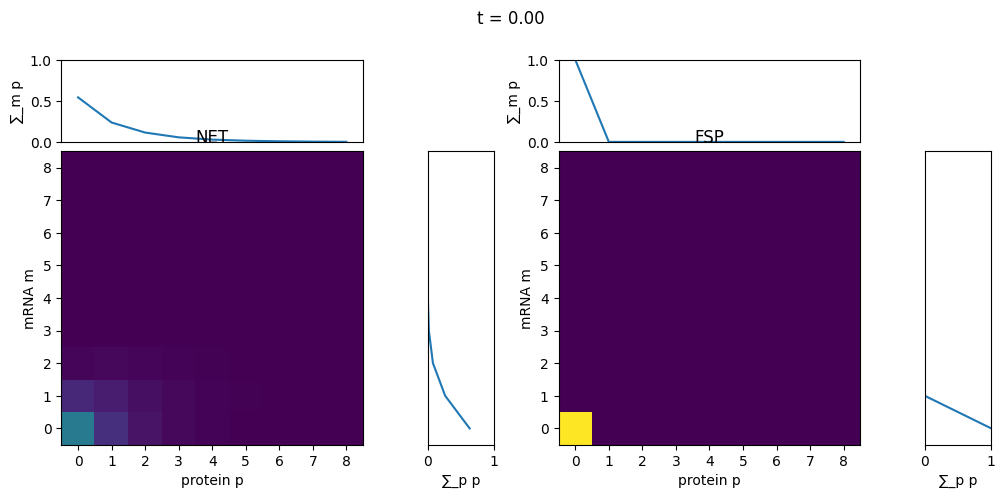

In [8]:
# Comparison between the two methods

# ===============================
# Compare NET vs FSP with marginals
# ===============================
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def _net_grid_at_time(net, t_scalar):
    """Return full (M+1,P+1) grid of p_theta(m,p|t)."""
    # vectorize all states
    m_all = torch.arange(M_MAX + 1, device=DEVICE)
    p_all = torch.arange(P_MAX + 1, device=DEVICE)
    M, P = torch.meshgrid(m_all, p_all, indexing="ij")
    oh_m = F.one_hot(M.flatten(), M_MAX + 1).float()
    oh_p = F.one_hot(P.flatten(), P_MAX + 1).float()
    t_vec = torch.full((oh_m.shape[0],), float(t_scalar), device=DEVICE)

    # eval p(m,p|t) (use hard one-hot also as soft conditioner, matching your API)
    with torch.no_grad():
        probs = net.get_probability(oh_m, oh_p, oh_m, t_vec).clamp_min(0)
    return probs.view(M_MAX + 1, P_MAX + 1).detach().cpu().numpy()


def _fsp_vec_at_time(t_scalar, t_grid, y_matrix):
    """
    Linear interpolation of the FSP solution at scalar time.
    y_matrix shape: (N_STATES, T); t_grid shape: (T,)
    Returns y_vec length N_STATES (numpy).
    """
    if t_scalar <= t_grid[0]:
        return y_matrix[:, 0]
    if t_scalar >= t_grid[-1]:
        return y_matrix[:, -1]
    i1 = np.searchsorted(t_grid, t_scalar)
    i0 = i1 - 1
    t0, t1 = t_grid[i0], t_grid[i1]
    w = (t_scalar - t0) / (t1 - t0 + 1e-12)
    return (1.0 - w) * y_matrix[:, i0] + w * y_matrix[:, i1]


def _grid_from_vec(y_vec):
    """Reshape flat N_STATES vector to (M+1,P+1) grid."""
    return y_vec.reshape(M_MAX + 1, P_MAX + 1)


def animate_compare(net, fsp_t, fsp_y, *, t_max, num_frames=50, normalize="sum", fps=10):
    """
    Side-by-side animation:
      left  : NET heatmap + marginals
      right : FSP heatmap + marginals
    normalize: 'sum' | 'max' | None (applied independently to each panel)
    """
    # ---- figure layout (2 columns: each has top marginal, heatmap, right marginal) ----
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(
        2, 4,
        width_ratios=[1.0, 0.22, 1.0, 0.22],
        height_ratios=[0.28, 1.0],
        wspace=0.35, hspace=0.05
    )

    # NET panel
    ax_top_net   = fig.add_subplot(gs[0, 0])
    ax_heat_net  = fig.add_subplot(gs[1, 0])
    ax_right_net = fig.add_subplot(gs[1, 1])

    # FSP panel
    ax_top_fsp   = fig.add_subplot(gs[0, 2])
    ax_heat_fsp  = fig.add_subplot(gs[1, 2])
    ax_right_fsp = fig.add_subplot(gs[1, 3])

    # initial time
    t0 = 0.0
    grid_net = _net_grid_at_time(net, t0)
    grid_fsp = _grid_from_vec(_fsp_vec_at_time(t0, fsp_t, fsp_y))

    def _normalize(grid):
        if normalize == "sum":
            s = grid.sum()
            return grid / s if s > 0 else grid
        elif normalize == "max":
            m = grid.max()
            return grid / m if m > 0 else grid
        return grid

    grid_net = _normalize(grid_net)
    grid_fsp = _normalize(grid_fsp)

    # heatmaps (fix color scale to [0,1] if normalized by 'sum' or 'max')
    vmin, vmax = (0.0, 1.0) if normalize in ("sum", "max") else (None, None)
    im_net = ax_heat_net.imshow(
        grid_net, origin="lower", aspect="auto",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )
    im_fsp = ax_heat_fsp.imshow(
        grid_fsp, origin="lower", aspect="auto",
        vmin=vmin, vmax=vmax, cmap="viridis"
    )

    ax_heat_net.set_title("NET"); ax_heat_fsp.set_title("FSP")
    ax_heat_net.set_xlabel("protein p"); ax_heat_fsp.set_xlabel("protein p")
    ax_heat_net.set_ylabel("mRNA m");    ax_heat_fsp.set_ylabel("mRNA m")

    # ticks at integers (optional: thin out if large)
    ax_heat_net.set_xticks(np.arange(P_MAX + 1))
    ax_heat_net.set_yticks(np.arange(M_MAX + 1))
    ax_heat_fsp.set_xticks(np.arange(P_MAX + 1))
    ax_heat_fsp.set_yticks(np.arange(M_MAX + 1))

    # marginals (top: over p, right: over m)
    p_marg_net, m_marg_net = grid_net.sum(0), grid_net.sum(1)
    p_marg_fsp, m_marg_fsp = grid_fsp.sum(0), grid_fsp.sum(1)

    # top (p-marginal): plot as lines
    ln_top_net, = ax_top_net.plot(np.arange(P_MAX + 1), p_marg_net)
    ln_top_fsp, = ax_top_fsp.plot(np.arange(P_MAX + 1), p_marg_fsp)
    ax_top_net.set_xlim(-0.5, P_MAX + 0.5)
    ax_top_fsp.set_xlim(-0.5, P_MAX + 0.5)
    ax_top_net.set_xticks([]); ax_top_fsp.set_xticks([])
    ax_top_net.set_ylabel("∑_m p"); ax_top_fsp.set_ylabel("∑_m p")

    # right (m-marginal): horizontal lines
    ln_right_net, = ax_right_net.plot(m_marg_net, np.arange(M_MAX + 1))
    ln_right_fsp, = ax_right_fsp.plot(m_marg_fsp, np.arange(M_MAX + 1))
    ax_right_net.set_ylim(-0.5, M_MAX + 0.5)
    ax_right_fsp.set_ylim(-0.5, M_MAX + 0.5)
    ax_right_net.set_yticks([]); ax_right_fsp.set_yticks([])
    ax_right_net.set_xlabel("∑_p p"); ax_right_fsp.set_xlabel("∑_p p")

    # set reasonable y-lims/x-lims for marginals (normalized → ≤1)
    if normalize in ("sum", "max"):
        ax_top_net.set_ylim(0, 1.0)
        ax_top_fsp.set_ylim(0, 1.0)
        ax_right_net.set_xlim(0, 1.0)
        ax_right_fsp.set_xlim(0, 1.0)

    # shared super-title
    suptitle = fig.suptitle(f"t = {t0:.2f}")

    # ---- animator ----
    def update(frame):
        t_val = frame * t_max / max(1, (num_frames - 1))
        grid_n = _normalize(_net_grid_at_time(net, t_val))
        grid_f = _normalize(_grid_from_vec(_fsp_vec_at_time(t_val, fsp_t, fsp_y)))

        # update heatmaps
        im_net.set_data(grid_n)
        im_fsp.set_data(grid_f)

        # update marginals
        p_n, m_n = grid_n.sum(0), grid_n.sum(1)
        p_f, m_f = grid_f.sum(0), grid_f.sum(1)
        ln_top_net.set_ydata(p_n)
        ln_top_fsp.set_ydata(p_f)
        ln_right_net.set_xdata(m_n)
        ln_right_fsp.set_xdata(m_f)

        suptitle.set_text(f"t = {t_val:.2f}")
        return (im_net, im_fsp, ln_top_net, ln_top_fsp, ln_right_net, ln_right_fsp, suptitle)

    ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=False, interval=1000//fps)
    return ani

# 1) Solve FSP
t_fsp, y_fsp = solve_fsp(crn, t_span=(0, 1.5), steps=50)  # y_fsp shape: (N_STATES, T)

# 2) Train your net (as you already do)
# ... training code ...
# net = ...

# 3) Animate comparison
ani = animate_compare(net, t_fsp, y_fsp, t_max=1.5, num_frames=50, normalize="sum", fps=10)
ani.save("compare_net_vs_fsp.gif", writer="pillow", fps=10)



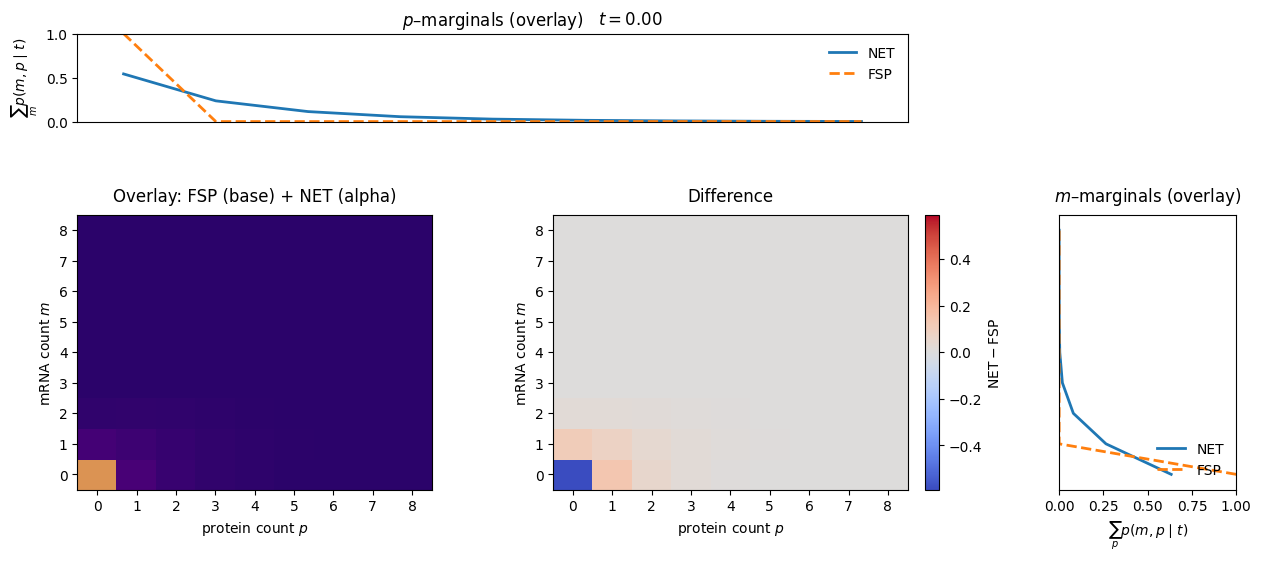

In [9]:
# ===============================
# Overlay (NET vs FSP) w/ LaTeX labels
# ===============================
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def _eval_probs_api(net, oh_m, oh_p, t_vec):
    try:
        return net.get_probability(oh_m, oh_p, oh_m, t_vec)
    except TypeError:
        return net.get_probability(oh_m, oh_p, t_vec)

def _net_grid_at_time(net, t_scalar):
    m_all = torch.arange(M_MAX + 1, device=DEVICE)
    p_all = torch.arange(P_MAX + 1, device=DEVICE)
    M, P = torch.meshgrid(m_all, p_all, indexing="ij")
    oh_m = F.one_hot(M.flatten(), M_MAX + 1).float()
    oh_p = F.one_hot(P.flatten(), P_MAX + 1).float()
    t_vec = torch.full((oh_m.shape[0],), float(t_scalar), device=DEVICE)
    with torch.no_grad():
        probs = _eval_probs_api(net, oh_m, oh_p, t_vec).clamp_min(0)
    return probs.view(M_MAX + 1, P_MAX + 1).detach().cpu().numpy()

def _fsp_vec_at_time(t_scalar, t_grid, y_matrix):
    if t_scalar <= t_grid[0]:   return y_matrix[:, 0]
    if t_scalar >= t_grid[-1]:  return y_matrix[:, -1]
    i1 = np.searchsorted(t_grid, t_scalar); i0 = i1 - 1
    t0, t1 = t_grid[i0], t_grid[i1]
    w = (t_scalar - t0) / (t1 - t0 + 1e-12)
    return (1.0 - w) * y_matrix[:, i0] + w * y_matrix[:, i1]

def _grid_from_vec(y_vec):
    return y_vec.reshape(M_MAX + 1, P_MAX + 1)

def animate_overlay_and_diff(
    net, fsp_t, fsp_y, *,
    t_max, num_frames=50, normalize="sum", fps=10, diff_abs=False,
    overlay_alpha=0.45,
    use_tex=False  # set True if you want full LaTeX (needs a TeX install)
):
    # Optional: full LaTeX rendering (requires system LaTeX)
    if use_tex:
        from matplotlib import rcParams
        rcParams["text.usetex"] = True
        rcParams["font.family"] = "serif"
        # rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"

    def _normalize(grid):
        if normalize == "sum":
            s = grid.sum();  return grid / s if s > 0 else grid
        if normalize == "max":
            m = grid.max();  return grid / m if m > 0 else grid
        return grid

    fig = plt.figure(constrained_layout=True, figsize=(12.5, 5.5))
    gs = fig.add_gridspec(
        2, 3,
        width_ratios=[2.0, 2.0, 1.0],
        height_ratios=[0.32, 1.0],
        wspace=0.10, hspace=0.20
    )
    ax_top     = fig.add_subplot(gs[0, :2])  # overlaid p-marginals
    ax_overlay = fig.add_subplot(gs[1, 0])   # overlay: FSP base + NET alpha heatmap
    ax_diff    = fig.add_subplot(gs[1, 1])   # difference heatmap
    ax_right   = fig.add_subplot(gs[1, 2])   # overlaid m-marginals

    t0 = 0.0
    grid_net = _normalize(_net_grid_at_time(net, t0))
    grid_fsp = _normalize(_grid_from_vec(_fsp_vec_at_time(t0, fsp_t, fsp_y)))

    vmin = 0.0 if normalize else None
    vmax = 1.0 if normalize else None

    im_base = ax_overlay.imshow(
        grid_fsp, origin="lower", aspect="auto", cmap="viridis", vmin=vmin, vmax=vmax
    )
    im_overlay = ax_overlay.imshow(
        grid_net, origin="lower", aspect="auto", cmap="plasma", vmin=vmin, vmax=vmax, alpha=overlay_alpha
    )
    ax_overlay.set_title(r"Overlay: FSP (base) + NET (alpha)", pad=10)
    ax_overlay.set_xlabel(r"protein count $p$")
    ax_overlay.set_ylabel(r"mRNA count $m$")
    ax_overlay.set_xticks(np.arange(P_MAX + 1)); ax_overlay.set_yticks(np.arange(M_MAX + 1))

    diff0 = (np.abs(grid_net - grid_fsp) if diff_abs else (grid_net - grid_fsp))
    dv = (np.max(np.abs(diff0)) or 1e-6) if not diff_abs else (np.max(diff0) or 1e-6)
    if diff_abs:
        im_diff = ax_diff.imshow(diff0, origin="lower", aspect="auto", cmap="magma", vmin=0.0, vmax=dv)
        cbar = fig.colorbar(im_diff, ax=ax_diff, fraction=0.046, pad=0.05)
        cbar.set_label(r"$\lvert\,\text{NET}-\text{FSP}\,\rvert$")
    else:
        im_diff = ax_diff.imshow(diff0, origin="lower", aspect="auto", cmap="coolwarm", vmin=-dv, vmax=dv)
        cbar = fig.colorbar(im_diff, ax=ax_diff, fraction=0.046, pad=0.05)
        cbar.set_label(r"$\text{NET}-\text{FSP}$")
    ax_diff.set_title(r"Difference", pad=10)
    ax_diff.set_xlabel(r"protein count $p$")
    ax_diff.set_ylabel(r"mRNA count $m$")
    ax_diff.set_xticks(np.arange(P_MAX + 1)); ax_diff.set_yticks(np.arange(M_MAX + 1))

    # p–marginals (top): $\sum_m p(m,p\mid t)$
    p_net, p_fsp = grid_net.sum(0), grid_fsp.sum(0)
    ln_p_net, = ax_top.plot(np.arange(P_MAX + 1), p_net, label=r"NET", lw=2)
    ln_p_fsp, = ax_top.plot(np.arange(P_MAX + 1), p_fsp, label=r"FSP", lw=2, linestyle="--")
    ax_top.set_xlim(-0.5, P_MAX + 0.5); ax_top.set_xticks([])
    ax_top.set_ylabel(r"$\sum_{m} p(m,p\mid t)$")
    if normalize in ("sum", "max"): ax_top.set_ylim(0, 1.0)
    ax_top.legend(loc="upper right", frameon=False)
    ax_top.set_title(r"$p$–marginals (overlay)", pad=6)

    # m–marginals (right): $\sum_p p(m,p\mid t)$
    m_net, m_fsp = grid_net.sum(1), grid_fsp.sum(1)
    ln_m_net, = ax_right.plot(m_net, np.arange(M_MAX + 1), label=r"NET", lw=2)
    ln_m_fsp, = ax_right.plot(m_fsp, np.arange(M_MAX + 1), label=r"FSP", lw=2, linestyle="--")
    ax_right.set_ylim(-0.5, M_MAX + 0.5); ax_right.set_yticks([])
    ax_right.set_xlabel(r"$\sum_{p} p(m,p\mid t)$")
    if normalize in ("sum", "max"): ax_right.set_xlim(0, 1.0)
    ax_right.legend(loc="lower right", frameon=False)
    ax_right.set_title(r"$m$–marginals (overlay)", pad=10)

    suptitle = fig.suptitle(rf"$t = {t0:.2f}$", y=0.99)

    def update(frame):
        t_val = frame * t_max / max(1, (num_frames - 1))
        gn = _normalize(_net_grid_at_time(net, t_val))
        gf = _normalize(_grid_from_vec(_fsp_vec_at_time(t_val, fsp_t, fsp_y)))

        im_base.set_data(gf)
        im_overlay.set_data(gn)

        d = (np.abs(gn - gf) if diff_abs else (gn - gf))
        im_diff.set_data(d)

        ln_p_net.set_ydata(gn.sum(0)); ln_p_fsp.set_ydata(gf.sum(0))
        ln_m_net.set_xdata(gn.sum(1)); ln_m_fsp.set_xdata(gf.sum(1))

        suptitle.set_text(rf"$t = {t_val:.2f}$")
        return (im_base, im_overlay, im_diff, ln_p_net, ln_p_fsp, ln_m_net, ln_m_fsp, suptitle)

    ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=False, interval=1000//fps)
    return ani

# ---- Usage example ----
t_fsp, y_fsp = solve_fsp(crn, t_span=(0, 1.5), steps=50)
ani = animate_overlay_and_diff(net, t_fsp, y_fsp, t_max=1.5, num_frames=50, normalize="sum", fps=10, diff_abs=False)
ani.save("overlay_diff_marginals.gif", writer="pillow", fps=10)
